### Simulation (SPN)
- 3 종류의 파라미터 세트로 실험 진행 
    - Untangling Basal Ganglia Network Dynamics and Function
        - 시간에 따라 I를 바꿔가며 입력 
    - Action selection in the rhythmic brain: The role of the basal ganglia and tremor
    - The onset of motor learning impairments in Parkinson’s disease: a computational investigation

- Future work (input): https://brian2.readthedocs.io/en/stable/examples/frompapers.Wang_2002.html

In [2]:
### Library
from brian2 import *
import brian2 as br
from brian2tools import *
import matplotlib.pyplot as plt
import random
import numpy as np
from brian2.units import *
from neuron import h, gui
from brian2 import ms, mV, pA, pF, siemens, amp, second, NeuronGroup, defaultclock, run
import json
import numpy as np

--No graphics will be displayed.


In [3]:
# Neuron parameters (Set 1)
# eNeuro

N = 100
C = 80 * br.pF 
K = 1

KAPA = 0.0289   # Humphries etal 2009a
ALPHA = 0.032   # Humphries etal 2009a

Earliest time when v stabilizes at v_reset (in ms): 0. s


INFO:root:building '_cython_magic_34a564dd1e977e4d1381cde5ad03b558' extension
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -ftree-vectorize -fPIC -fstack-protector-strong -O2 -pipe -fPIE -isystem /opt/anaconda3/envs/brain/include -D_FORTIFY_SOURCE=2 -isystem /opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/numpy/core/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/brian2/synapses -I/opt/anaconda3/envs/brain/include/python3.9 -c /Users/tacolab4/Library/Caches/cython/brian_extensions/_cython_magic_34a564dd1e977e4d1381cde5ad03b558.cpp -o /Users/tacolab4/Library/Caches/cython/brian_extensions/Users/tacolab4/Library/Caches/cython/brian_extensions/_cython_magic_34a564dd1e977e4d1381cde5ad03b558.o -w

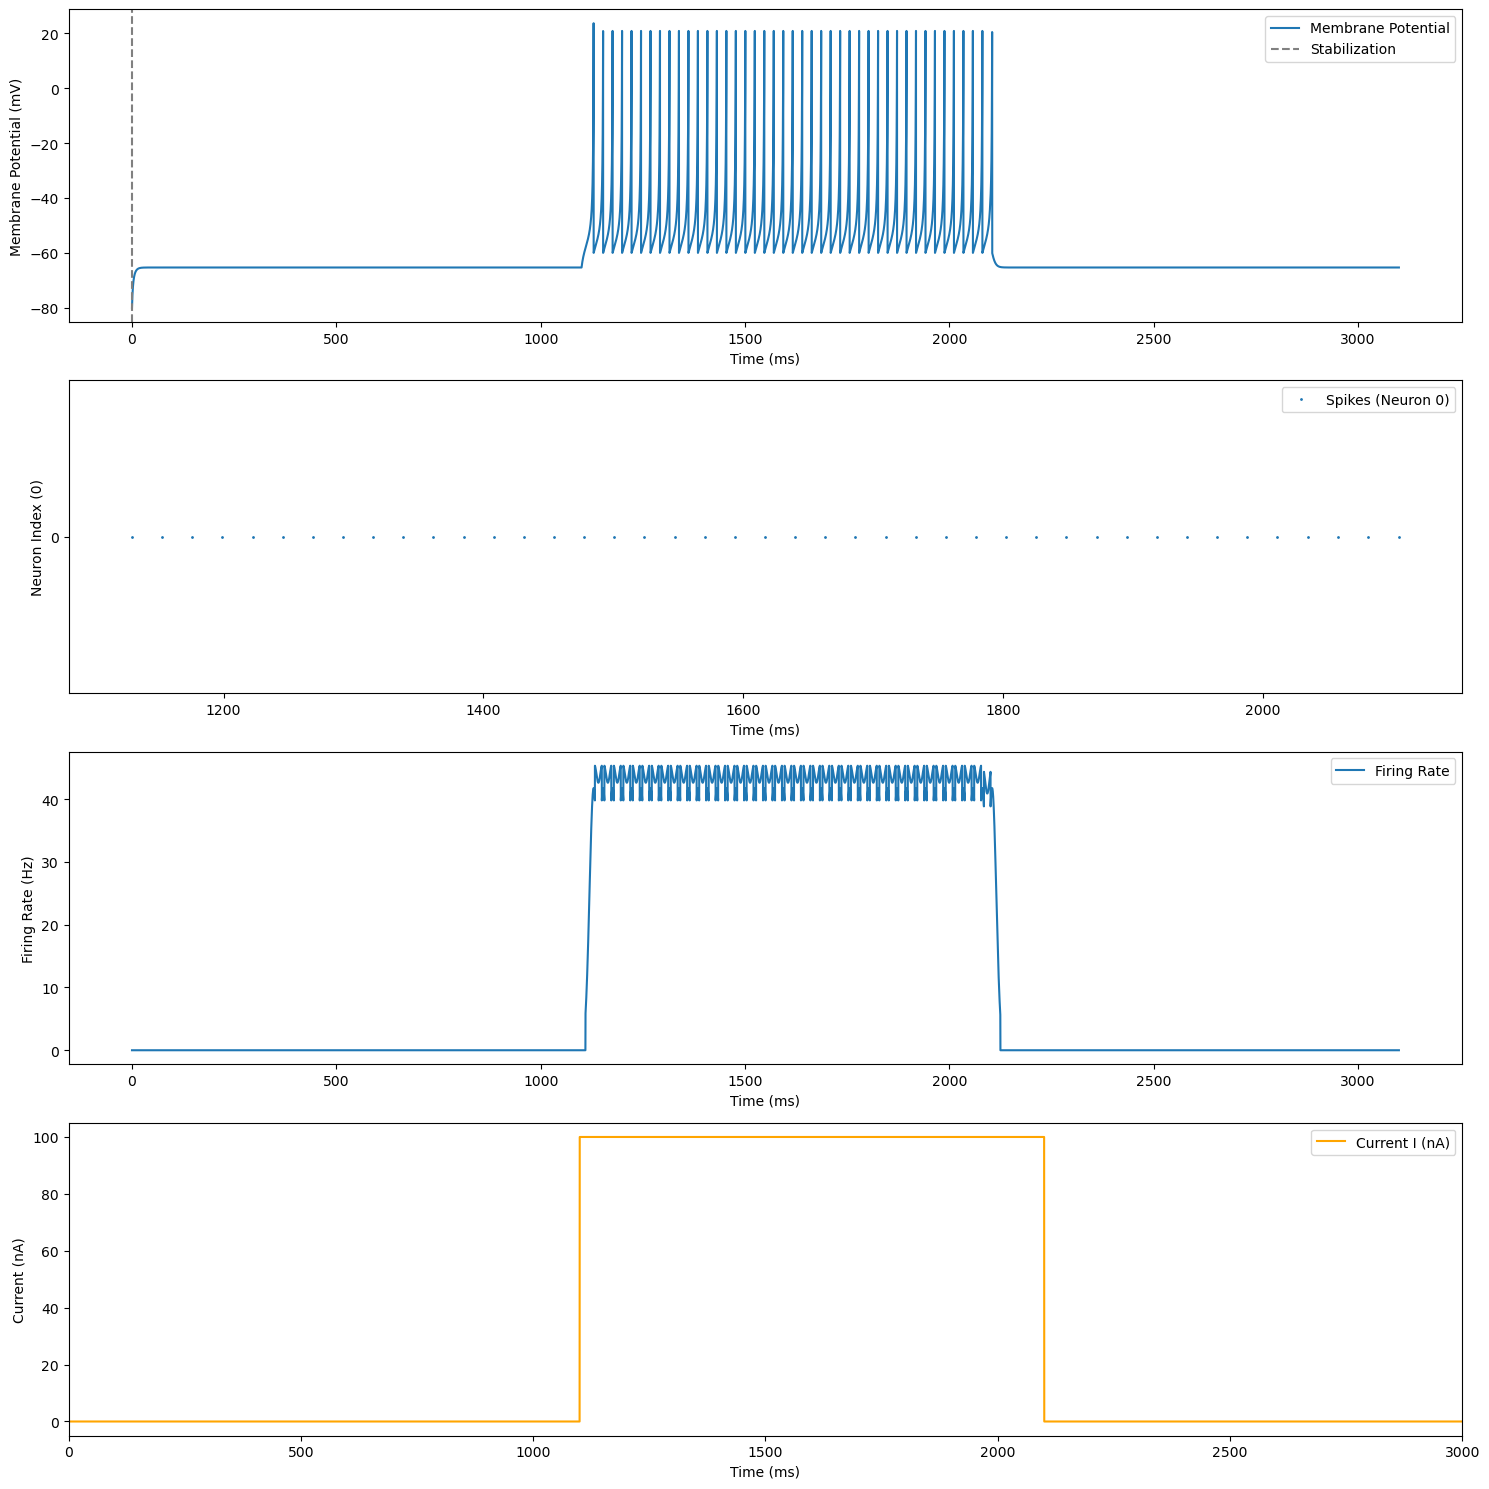

In [5]:
### Set 1 Final 

eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
c       : volt
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

dSPN.v = -80 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.2 / ms
dSPN.b = 0.025 / ms
dSPN.c = -60 * mV
dSPN.d = 0 * mV / ms
dSPN.k = 1
dSPN.vr = -64.4 * mV 
dSPN.vt = -50 * mV
dSPN.vpeak = 25 * mV
dSPN.I = 0 * pA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5

# Parameter Settings 
simulation_time = 1000 * ms 
time_after_increase = 1000 * ms  
time_after_decrease = 1000 * ms 

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)
rate_monitor = PopulationRateMonitor(dSPN)  # 10ms의 bin 크기

net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
net.run(simulation_time)

# Find the Stabilization time point
v_reset = -66 * mV 
membrane_potential = dv_monitor.v  
times = dv_monitor.t 

matching_indices = np.where(membrane_potential / mV >= v_reset / mV)[0]

if len(matching_indices) > 0:
    earliest_time_stabilized = times[matching_indices[0]] * 1000
else:
    earliest_time_stabilized = None

print("Earliest time when v stabilizes at v_reset (in ms):", earliest_time_stabilized)

### Simulation 
dv_monitor_new = StateMonitor(dSPN, variables='v', record=True)
spike_monitor_new = SpikeMonitor(dSPN)
rate_monitor_new = PopulationRateMonitor(dSPN)  # 10ms의 bin 크기
current_monitor = StateMonitor(dSPN, variables='I', record=True)

net.add(dv_monitor_new, spike_monitor_new, rate_monitor_new, current_monitor)

# Input current 
if earliest_time_stabilized is not None:
    # Increase I 
    wait_time_after_stabilization = 100 * ms
    net.run(wait_time_after_stabilization)
    dSPN.I = 100 * pA
    net.run(time_after_increase)
    
    # decrease I
    dSPN.I = 0 * pA
    net.run(time_after_decrease)

    # resimulation 
    net.run(simulation_time - earliest_time_stabilized - time_after_increase - time_after_decrease)
else:
    print("v do not reach v_reset, stop simulation")

### visualization 
plt.figure(figsize=(15, 15))

plt.subplot(4, 1, 1)
plt.plot(dv_monitor.t / ms, dv_monitor.v[0] / mV, label='Membrane Potential')
plt.axvline(x=earliest_time_stabilized / ms, color='gray', linestyle='--', label='Stabilization')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.legend()

plt.subplot(4, 1, 2)
spikes_of_neuron_0 = spike_monitor.i[spike_monitor.i == 0]  # 첫 번째 뉴런의 스파이크 인덱스
spike_times_of_neuron_0 = spike_monitor.t[spike_monitor.i == 0]  # 첫 번째 뉴런의 스파이크 발생 시간
plt.plot(spike_times_of_neuron_0 / ms, spikes_of_neuron_0, '.', markersize=2, label='Spikes (Neuron 0)')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index (0)')
plt.yticks([0])  # y축에 0만 표시
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(rate_monitor.t / ms, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing Rate')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.legend()

# Input Current Plot
plt.subplot(4, 1, 4)
initial_time = np.arange(0, 1000, 1)  # From 0 to 1000 ms
initial_current = np.zeros_like(initial_time)  # All values are 0 for the first 1000 ms
# Concatenate initial current with the current monitor values
total_time = np.concatenate((initial_time, current_monitor.t / ms))
total_current = np.concatenate((initial_current, current_monitor.I[0] / pA))

# Plot the current
plt.plot(total_time, total_current, label='Current I (nA)', color='orange')
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.xlim(0, (simulation_time + time_after_increase + time_after_decrease)/ms)  # Ensure x-axis starts at 0
plt.legend()

plt.tight_layout()
plt.show()

Earliest time when v stabilizes at v_reset (in ms): 0. s


INFO:root:building '_cython_magic_1da8b6b5a3380f523416b553bfd48538' extension
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -ftree-vectorize -fPIC -fstack-protector-strong -O2 -pipe -fPIE -isystem /opt/anaconda3/envs/brain/include -D_FORTIFY_SOURCE=2 -isystem /opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/numpy/core/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/brian2/synapses -I/opt/anaconda3/envs/brain/include/python3.9 -c /Users/tacolab4/Library/Caches/cython/brian_extensions/_cython_magic_1da8b6b5a3380f523416b553bfd48538.cpp -o /Users/tacolab4/Library/Caches/cython/brian_extensions/Users/tacolab4/Library/Caches/cython/brian_extensions/_cython_magic_1da8b6b5a3380f523416b553bfd48538.o -w

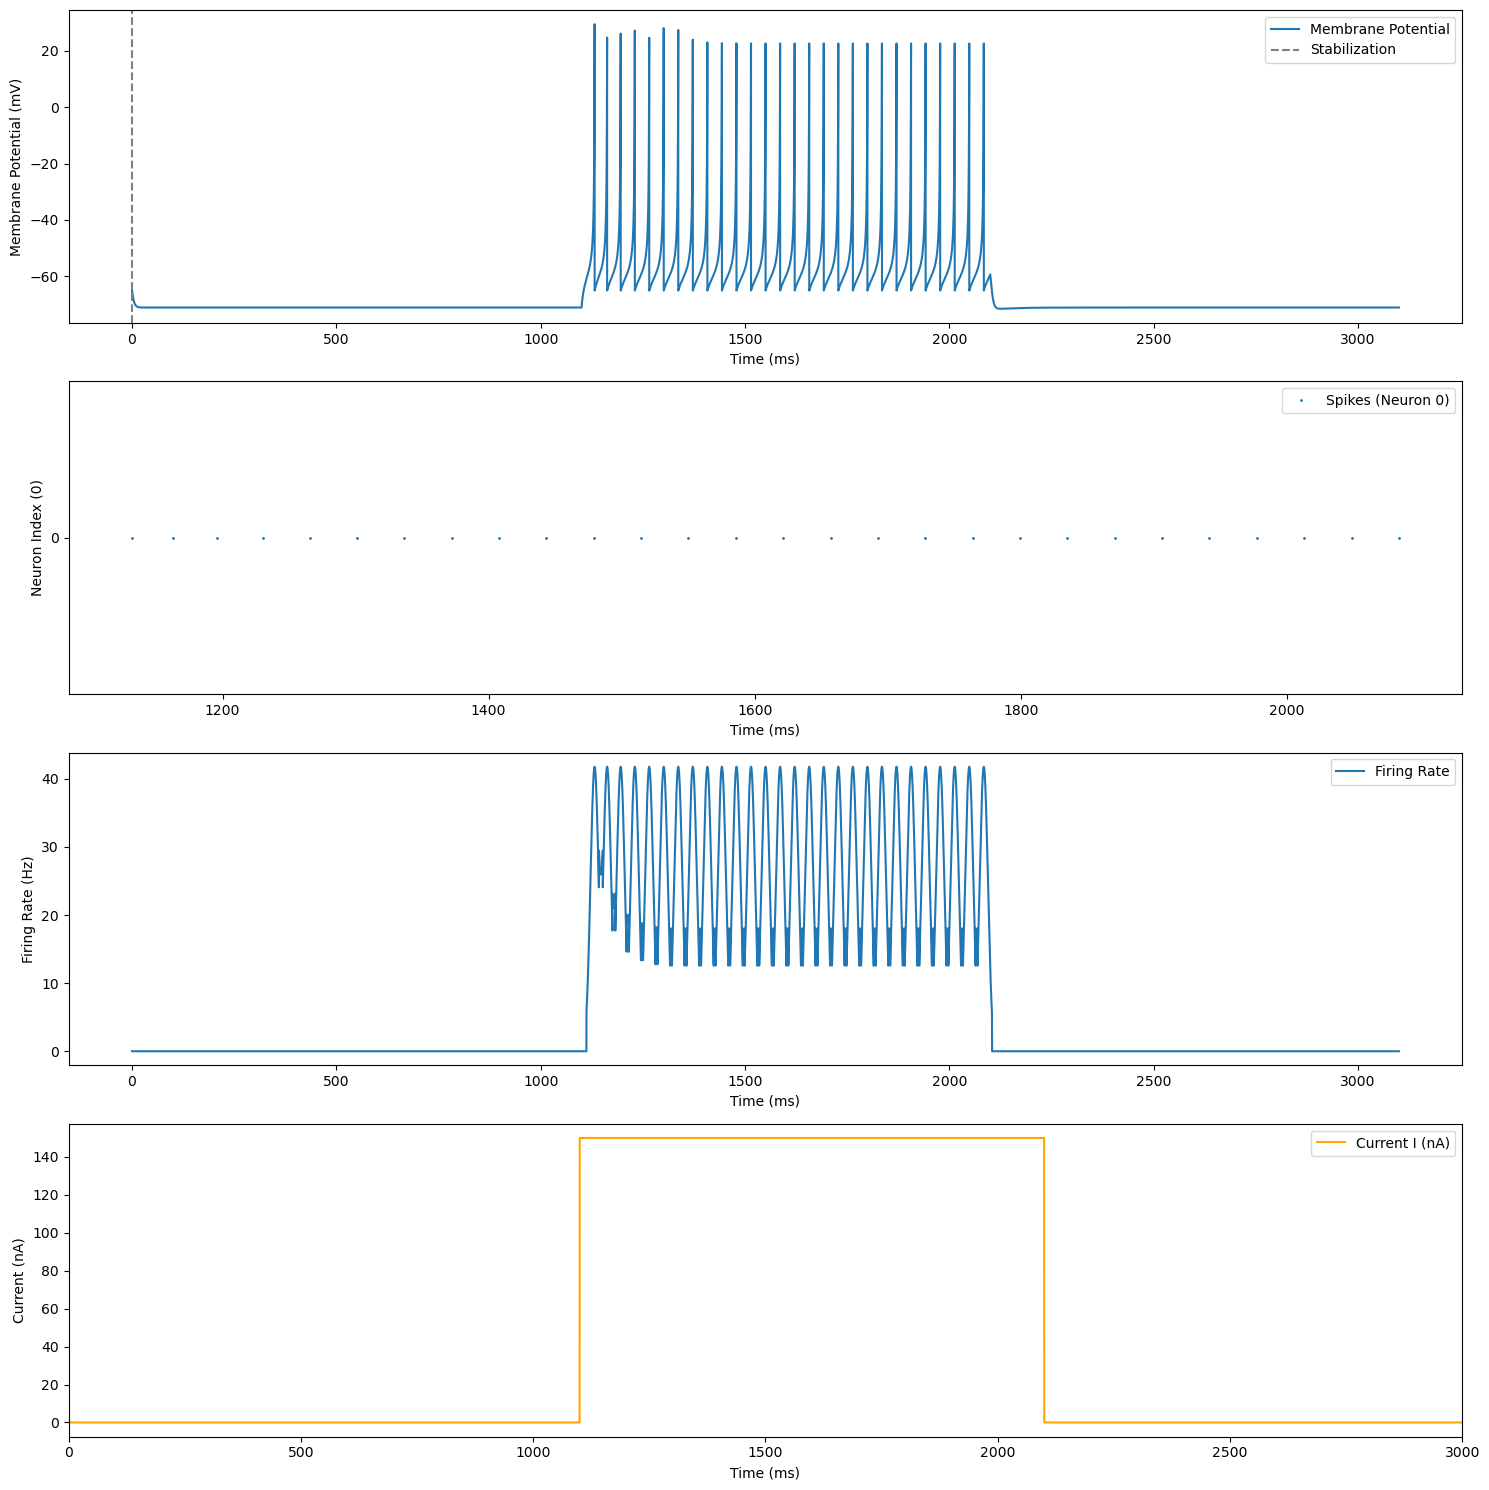

In [8]:
### Set 2

eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
c       : volt
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

dSPN.v = -65 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.02 / ms
dSPN.b = 0.2 / ms
dSPN.c = -65 * mV
dSPN.d = 8 * mV / ms
dSPN.k = 1
dSPN.vr = -70 * mV 
dSPN.vt = -50 * mV
dSPN.vpeak = 30 * mV
dSPN.I = 0 * pA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5

# Parameter Settings 
simulation_time = 1000 * ms 
time_after_increase = 1000 * ms  
time_after_decrease = 1000 * ms 

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)
rate_monitor = PopulationRateMonitor(dSPN)  # 10ms의 bin 크기

net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
net.run(simulation_time)

# Find the Stabilization time point
v_reset = -65 * mV 
membrane_potential = dv_monitor.v  
times = dv_monitor.t 

matching_indices = np.where(membrane_potential / mV >= v_reset / mV)[0]

if len(matching_indices) > 0:
    earliest_time_stabilized = times[matching_indices[0]] * 1000
else:
    earliest_time_stabilized = None

print("Earliest time when v stabilizes at v_reset (in ms):", earliest_time_stabilized)

### Simulation 
dv_monitor_new = StateMonitor(dSPN, variables='v', record=True)
spike_monitor_new = SpikeMonitor(dSPN)
rate_monitor_new = PopulationRateMonitor(dSPN)  # 10ms의 bin 크기
current_monitor = StateMonitor(dSPN, variables='I', record=True)

net.add(dv_monitor_new, spike_monitor_new, rate_monitor_new, current_monitor)

# Input current 
if earliest_time_stabilized is not None:
    # Increase I 
    wait_time_after_stabilization = 100 * ms
    net.run(wait_time_after_stabilization)
    dSPN.I = 150 * pA # 100에서 spike 발생 x 
    net.run(time_after_increase)
    
    # decrease I
    dSPN.I = 0 * pA
    net.run(time_after_decrease)

    # resimulation 
    net.run(simulation_time - earliest_time_stabilized - time_after_increase - time_after_decrease)
else:
    print("v do not reach v_reset, stop simulation")

### visualization 
plt.figure(figsize=(15, 15))

plt.subplot(4, 1, 1)
plt.plot(dv_monitor.t / ms, dv_monitor.v[0] / mV, label='Membrane Potential')
plt.axvline(x=earliest_time_stabilized / ms, color='gray', linestyle='--', label='Stabilization')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.legend()

plt.subplot(4, 1, 2)
spikes_of_neuron_0 = spike_monitor.i[spike_monitor.i == 0]  # 첫 번째 뉴런의 스파이크 인덱스
spike_times_of_neuron_0 = spike_monitor.t[spike_monitor.i == 0]  # 첫 번째 뉴런의 스파이크 발생 시간
plt.plot(spike_times_of_neuron_0 / ms, spikes_of_neuron_0, '.', markersize=2, label='Spikes (Neuron 0)')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index (0)')
plt.yticks([0])  # y축에 0만 표시
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(rate_monitor.t / ms, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing Rate')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.legend()

# Input Current Plot
plt.subplot(4, 1, 4)
initial_time = np.arange(0, 1000, 1)  # From 0 to 1000 ms
initial_current = np.zeros_like(initial_time)  # All values are 0 for the first 1000 ms
# Concatenate initial current with the current monitor values
total_time = np.concatenate((initial_time, current_monitor.t / ms))
total_current = np.concatenate((initial_current, current_monitor.I[0] / pA))

# Plot the current
plt.plot(total_time, total_current, label='Current I (nA)', color='orange')
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.xlim(0, (simulation_time + time_after_increase + time_after_decrease)/ms)  # Ensure x-axis starts at 0
plt.legend()

plt.tight_layout()
plt.show()

Earliest time when v stabilizes at v_reset (in ms): 0. s


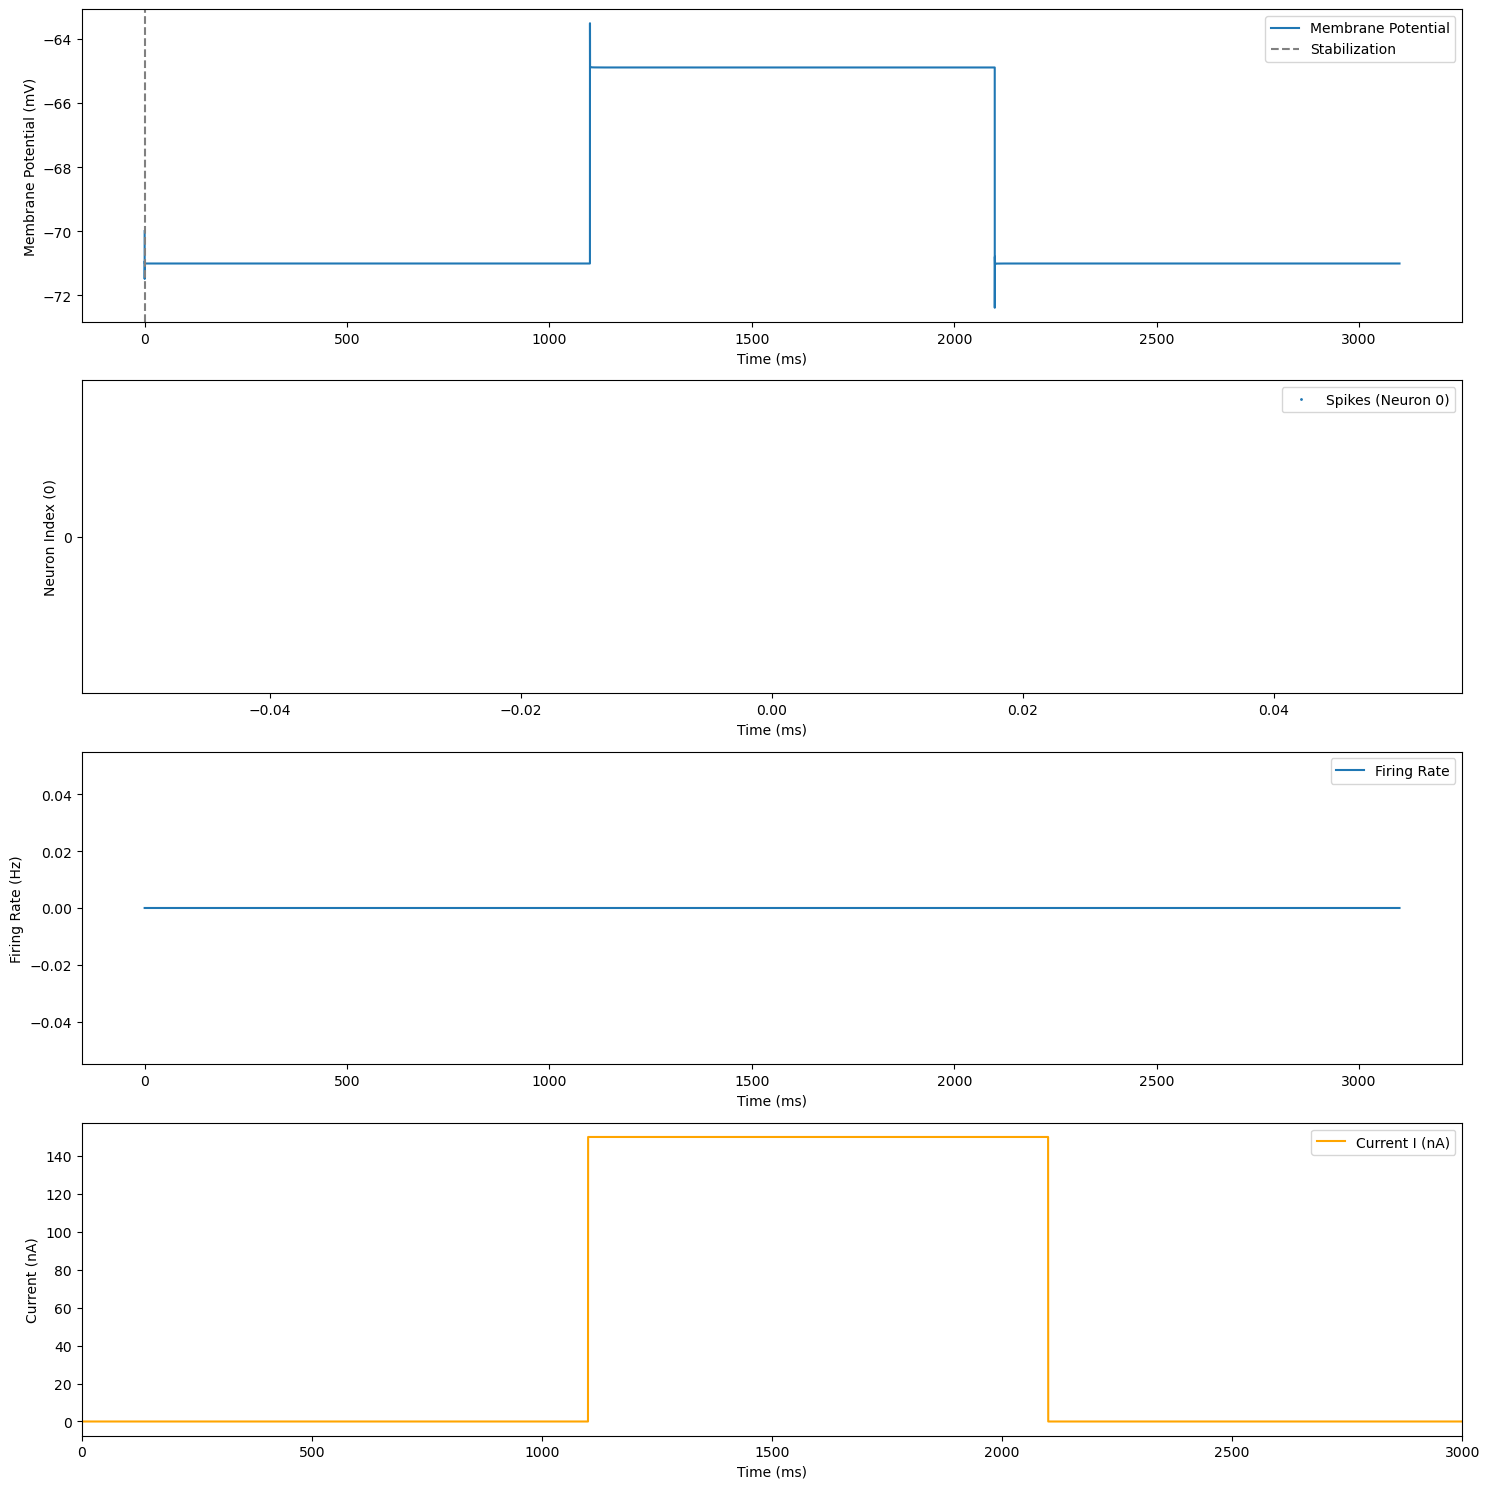

In [12]:
### Set 3: The onset of motor learning impairments in Parkinson’s disease: a computational investigation

eqs = '''
dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C: volt
du/dt = a*(b*(v-VR)-u) : volt/second
VR = vr*(1+KAPA*Dop1) : volt
K = k*(1-ALPHA*Dop2) : 1
a       : 1/second
b       : 1/second
c       : volt
d       : volt/second
k       : 1
vr      : volt
vt      : volt
vpeak   : volt
I : amp
Dop1      : 1
Dop2      : 1
'''

dSPN = NeuronGroup(N, model = eqs,
                    threshold='v > vpeak',
                    reset='v = c; u += d',
                    method='euler')

C = 2 * pF
dSPN.v = -70 * mV
dSPN.u = 0 * mV / ms
dSPN.a = 0.1 / ms
dSPN.b = 0.02 / ms
dSPN.c = -65 * mV
dSPN.d = 0 * mV / ms
dSPN.k = 1
dSPN.vr = -70 * mV 
dSPN.vt = -40 * mV
dSPN.vpeak = 25 * mV
dSPN.I = 0 * pA
dSPN.Dop1 = 0.5
dSPN.Dop2 = 0.5

# Parameter Settings 
simulation_time = 1000 * ms 
time_after_increase = 1000 * ms  
time_after_decrease = 1000 * ms 

dv_monitor = StateMonitor(dSPN, variables='v', record=True)
spike_monitor = SpikeMonitor(dSPN)
rate_monitor = PopulationRateMonitor(dSPN)  # 10ms의 bin 크기

net = Network(dSPN, dv_monitor, spike_monitor, rate_monitor)
net.run(simulation_time)

# Find the Stabilization time point
v_reset = -70 * mV 
membrane_potential = dv_monitor.v  
times = dv_monitor.t 

matching_indices = np.where(membrane_potential / mV >= v_reset / mV)[0]

if len(matching_indices) > 0:
    earliest_time_stabilized = times[matching_indices[0]] * 1000
else:
    earliest_time_stabilized = None

print("Earliest time when v stabilizes at v_reset (in ms):", earliest_time_stabilized)

### Simulation 
dv_monitor_new = StateMonitor(dSPN, variables='v', record=True)
spike_monitor_new = SpikeMonitor(dSPN)
rate_monitor_new = PopulationRateMonitor(dSPN)  # 10ms의 bin 크기
current_monitor = StateMonitor(dSPN, variables='I', record=True)

net.add(dv_monitor_new, spike_monitor_new, rate_monitor_new, current_monitor)

# Input current 
if earliest_time_stabilized is not None:
    # Increase I 
    wait_time_after_stabilization = 100 * ms
    net.run(wait_time_after_stabilization)
    dSPN.I = 150 * pA
    net.run(time_after_increase)
    
    # decrease I
    dSPN.I = 0 * pA
    net.run(time_after_decrease)

    # resimulation 
    net.run(simulation_time - earliest_time_stabilized - time_after_increase - time_after_decrease)
else:
    print("v do not reach v_reset, stop simulation")

### visualization 
plt.figure(figsize=(15, 15))

plt.subplot(4, 1, 1)
plt.plot(dv_monitor.t / ms, dv_monitor.v[0] / mV, label='Membrane Potential')
plt.axvline(x=earliest_time_stabilized / ms, color='gray', linestyle='--', label='Stabilization')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.legend()

plt.subplot(4, 1, 2)
spikes_of_neuron_0 = spike_monitor.i[spike_monitor.i == 0]  # 첫 번째 뉴런의 스파이크 인덱스
spike_times_of_neuron_0 = spike_monitor.t[spike_monitor.i == 0]  # 첫 번째 뉴런의 스파이크 발생 시간
plt.plot(spike_times_of_neuron_0 / ms, spikes_of_neuron_0, '.', markersize=2, label='Spikes (Neuron 0)')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index (0)')
plt.yticks([0])  # y축에 0만 표시
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(rate_monitor.t / ms, rate_monitor.smooth_rate(width=10*ms) / Hz, label='Firing Rate')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.legend()

# Input Current Plot
plt.subplot(4, 1, 4)
initial_time = np.arange(0, 1000, 1)  # From 0 to 1000 ms
initial_current = np.zeros_like(initial_time)  # All values are 0 for the first 1000 ms
# Concatenate initial current with the current monitor values
total_time = np.concatenate((initial_time, current_monitor.t / ms))
total_current = np.concatenate((initial_current, current_monitor.I[0] / pA))

# Plot the current
plt.plot(total_time, total_current, label='Current I (nA)', color='orange')
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.xlim(0, (simulation_time + time_after_increase + time_after_decrease)/ms)  # Ensure x-axis starts at 0
plt.legend()

plt.tight_layout()
plt.show()